Step1: Training the agent by SARSA, get a q_table to simulate human

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.82it/s]


1332.6708860759493


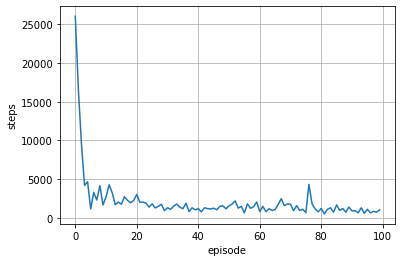

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import numpy as np
from tqdm import tqdm

env_name = "MountainCar-v0"
env = gym.make(env_name)
obs = env.reset()

n_states = 40
episodes = 100
alpha = 0.1
gamma = 0.9
max_stps = 300
epsilon = 0.08
env = env.unwrapped
env.seed()
np.random.seed(0)


def discretization(env, obs):
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_den = (env_high - env_low) / n_states
    pos_den = env_den[0]  # position
    vel_den = env_den[1]  # velocity速度
    pos_high = env_high[0]
    pos_low = env_low[0]
    vel_high = env_high[1]
    vel_low = env_low[1]
    pos_scaled = int((obs[0] - pos_low) / pos_den)
    vel_scaled = int((obs[1] - vel_low) / vel_den)
    return pos_scaled, vel_scaled


q_table = np.zeros((n_states, n_states, env.action_space.n))
total_steps = 0
Steps_sarsa = []
rewards_trace = []
r = []
for episode in tqdm(range(episodes)):
    #     print("Episode:", episode)
    obs = env.reset()
    rewards = 0
    steps = 0
    while True:
        #         env.render()
        pos, vel = discretization(env, obs)
        if np.random.uniform(low=0, high=1) < epsilon:
            a = np.random.choice(env.action_space.n)
        else:
            a = np.argmax(q_table[pos][vel])
        obs_, reward, terminate, _ = env.step(a)
        # total_reward += abs(obs[0] + 0.5)
        rewards += reward
        pos_, vel_ = discretization(env, obs_)
        if np.random.uniform(low=0, high=1) < epsilon:
            a_ = np.random.choice(env.action_space.n)
        else:
            a_ = np.argmax(q_table[pos][vel])


        # Q function update
        #
        # Q(s) = Q(s) + alpha(r + gamma*maxQ(s') - Q(s))
        q_table[pos][vel][a] = q_table[pos][vel][a] + alpha * (reward + gamma * q_table[pos_][vel_][a_] - q_table[pos][vel][a])
        steps += 1
        
        if terminate:
            r.append(q_table[pos][vel][a])
            rewards_trace.append(rewards)
            break
        obs = obs_
    Steps_sarsa.append(steps)
plt.plot(Steps_sarsa)
plt.grid()
plt.xlabel('episode')
plt.ylabel('steps')

# View the approximate number of steps after convergence
avg_sarsa = sum(Steps_sarsa[-80:-1])/len(Steps_sarsa[-80:-1])
print(avg_sarsa)

Step2: Mapping the q_table. Map the biggest reward in three actions to be 0, other two as -1

In [66]:
for i in range(39):
  for j in range(39):
    row = q_table[i][j]
    index = row.argmax()
    row.fill(-1)
    row[index] = 0

Step3: Using the mapped q_table to train TAMER

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.38it/s]


1909.8101265822784


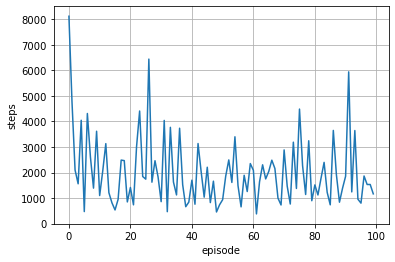

In [67]:
# Some initializations
#
n_states = 40
episodes = 100
# gamma = 0.99  # to 0
max_stps = 300
alpha = 0.001
# epsilon = 0.05  # to 0
env = env.unwrapped
env.seed()
np.random.seed(0)


def discretization(env, obs):
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_den = (env_high - env_low) / n_states
    pos_den = env_den[0]  # position
    vel_den = env_den[1]  # velocity速度
    pos_high = env_high[0]
    pos_low = env_low[0]
    vel_high = env_high[1]
    vel_low = env_low[1]
    pos_scaled = int((obs[0] - pos_low) / pos_den)
    vel_scaled = int((obs[1] - vel_low) / vel_den)
    return pos_scaled, vel_scaled


tamer_table = np.zeros((n_states, n_states, env.action_space.n))
total_steps = 0
Steps_tamer = []
max_steps = 10000
for episode in tqdm(range(episodes)):
    #     print("Episode:", episode)
    obs = env.reset()
    total_reward = 0
    steps = 0
    for i in range(max_steps):
        pos, vel = discretization(env, obs)
        a = np.argmax(tamer_table[pos][vel])   # 完全贪婪
        obs_, reward, terminate, _ = env.step(a)
        # total_reward += abs(obs[0] + 0.5)
        rewards += reward

        pos_, vel_ = discretization(env, obs_)
        a_ = np.argmax(tamer_table[pos][vel])
        
        if q_table[pos][vel][a]!= 0:
            tamer_table[pos][vel][a] = tamer_table[pos][vel][a] + alpha * (q_table[pos][vel][a] - tamer_table[pos][vel][a])
        
        steps += 1
        if terminate:
            break
        obs = obs_
    Steps_tamer.append(steps)

plt.plot(Steps_tamer)
plt.grid()
plt.xlabel('episode')
plt.ylabel('steps')

avg_tamer = sum(Steps_tamer[-80:-1])/len(Steps_tamer[-80:-1])
print(avg_tamer)

Tamer is not stable, could be not converge,could be better than Sarsa, could be worse than sarsa

Check different results to restart the kernel and rerun the entire code multipal times pls!!!

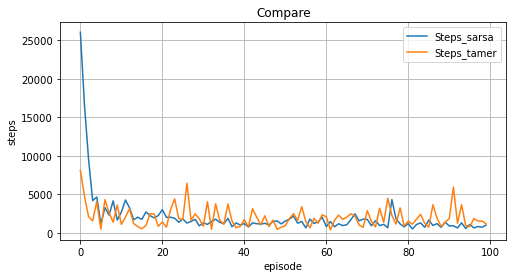

In [68]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(Steps_sarsa,label="Steps_sarsa")
ax.plot(Steps_tamer,label="Steps_tamer")
ax.set_title("Compare")
ax.set_xlabel("episode")
ax.set_ylabel("steps")
ax.grid(True)
plt.legend()